In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
%matplotlib inline

import sklearn
from sklearn import metrics
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

import implicit
import random


## Artist To Artist Similariy Testing

The data is originaly loaded in as a similarity matrix. The only edits to the mattrix were to convert data to binary.
This note book will be testing to see how adding things like Self Similarity and Symmetric Similarity effect Implicit ALS.

In [2]:
data = sparse.csr_matrix(sparse.load_npz('original.npz')[:])

In [3]:
def find_density(data):
    matrix_size = data.shape[0]*data.shape[1] # Number of possible interactions in the matrix
    num_artists = len(data.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - (num_artists/matrix_size))

    nonz = np.nonzero(data)[0]
    mat_size = data.shape[0]*data.shape[1]
    density = (nonz.size/mat_size) * 100
    return density

In [4]:
print("Matrix Information")
print("---------------------")
print("Density: ", find_density(data))
print("Shape: ", data.shape)

Matrix Information
---------------------
Density:  0.004389999227892156
Shape:  (145963, 145963)


## The cell below will graph the matrix
the matrix may appear dense, but this is only due to the size of the markers

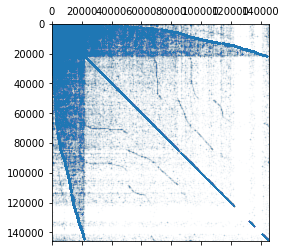

In [5]:
plt.spy(data, markersize=0.01)
plt.show()

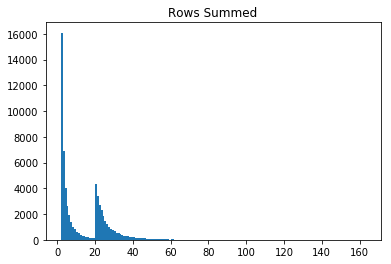

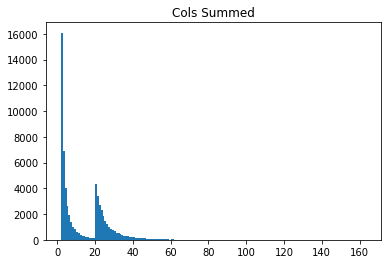

In [6]:
rows = np.sum(data, axis=1)
rni = rows[np.where(rows>1)]

plt.hist(rni.T, bins='auto')
plt.title("Rows Summed")
plt.show()

cols = np.sum(data, axis=0)
cni = cols[np.where(cols>1)]

plt.hist(cni.T, bins="auto")
plt.title("Cols Summed")
plt.show()




## Using Implicit Library on Artist-to-Artist Matrix

In [7]:
# Decrease size of matrix to train and test on
dc = data.copy()
test_data = data[:20000, :20000]

In [8]:
def make_train(sim, pct_test = 0.2):
    '''
    This function will take in the original artist-artist matrix and "mask" a percentage of the original similarities where a
    artist-artist interaction has taken place for use as a test set. The test set will contain all of the original similarities, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    sim - the original similarity matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of artist-artist interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original similarities. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the artist-artist pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original similarity matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected artist-artist indices, which artist rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    
    test_set = sim.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = sim.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  
    
    

In [9]:
product_train, product_test, product_users_altered = make_train(data, pct_test = 0.2)

## Implement Implicit ALS

In [51]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    Implicit weighted ALS taken from Hu, Koren, and Volinsky 2008. Designed for alternating least squares and implicit
    feedback based collaborative filtering. 
    
    parameters:
    
    training_set - Our matrix of ratings with shape m x m, where m is the number of artists.
    Should be a sparse csr matrix to save space. 
    
    lambda_val - Used for regularization during alternating least squares. Increasing this value may increase bias
    but decrease variance. Default is 0.1. 
    
    alpha - The parameter associated with the confidence matrix discussed in the paper, where Cui = 1 + alpha*Rui. 
    The paper found a default of 40 most effective. Decreasing this will decrease the variability in confidence between
    various ratings.
    
    iterations - The number of times to alternate between both artist feature vectors in
    alternating least squares. More iterations will allow better convergence at the cost of increased computation. 
    The authors found 10 iterations was sufficient, but more may be required to converge. 
    
    rank_size - The number of latent features in the artist feature vectors. The paper recommends varying this 
    between 20-200. Increasing the number of features may overfit but could reduce bias. 
    
    seed - Set the seed for reproducible results
    
    returns:
    
    The feature vector for artists. The dot product of these feature vectors should give you the expected 
    "rating" at each point in your original matrix. 
    '''
    
    # first set up our confidence matrix
    
    conf = (alpha*training_set) # To allow the matrix to stay sparse, I will add one later when each row is taken 
                                # and converted to dense. 
        
    num_artist = conf.shape[0] # Get the size of our original ratings matrix, m x m
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_artist, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_artist, rank_size))) # Normally this would be rank x n but we can 
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_artist)
    Y_eye = sparse.eye(num_artist)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
   
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_artist):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, don't need to subtract 1 since we never added it 
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        for i in range(num_artist):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, don't need to subtract 1 since we never added it
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons. 
    
    

In [52]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 1,
                                            rank_size = 20)

KeyboardInterrupt: 

In [10]:
# ALS using the Implicit Library
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)


This method is deprecated. Please use the AlternatingLeastSquares class instead
100%|██████████| 50.0/50 [00:21<00:00,  2.21it/s]


In [11]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   

In [12]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [13]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)
# AUC for our recommender system

KeyboardInterrupt: 